In [1]:
# univariate multi-step lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM, Dropout ,RepeatVector,TimeDistributed
from sklearn.preprocessing import MinMaxScaler

In [2]:
# load the new file
dataset = read_csv('./data/bitcoin_data.csv', date_parser = True)
dataset.drop(dataset.columns[0], axis=1,inplace = True)
dataset.head()


,close,open,high,low,Volume BTC,NewDateTime,returns,log_returns,SOPR,fundingRate,googleTrend
0,8431.82,8145.28,8455.00,8142.00,11041.87,2020-01-08 00:00:00,1.035179,0.034574,1.011291,0.01,89
1,8370.92,8431.82,8448.14,8328.89,7355.82,2020-01-08 01:00:00,0.992777,-0.007249,1.011291,0.01,86
2,8278.59,8370.92,8422.00,8256.74,4048.91,2020-01-08 02:00:00,0.988970,-0.011091,1.011291,0.01,75
3,8300.34,8278.59,8344.00,8244.93,3947.38,2020-01-08 03:00:00,1.002627,0.002624,1.011291,0.01,68
4,8344.63,8300.34,8355.87,8288.00,2374.55,2020-01-08 04:00:00,1.005336,0.005322,1.011291,0.01,68


In [3]:
# split into train and test
PDate = '2021-10-08'
train = dataset[dataset['NewDateTime']>= '2021-01-01'].copy()
train = train[train['NewDateTime']< PDate].copy()
test = dataset[dataset['NewDateTime']>= PDate].copy()
# restructure into windows of weekly data

train.drop(train.head(len(train)%168).index,inplace=True)
train = train.drop(['NewDateTime'], axis=1)
test.drop(test.tail(len(test)%168).index,inplace=True)
test = test.drop(['NewDateTime'], axis=1)

train.head()


,close,open,high,low,Volume BTC,returns,log_returns,SOPR,fundingRate,googleTrend
11417,37822.09,37045.45,37913.72,37038.97,4315.490397,1.020965,0.020748,1.055925,0.1003,44
11418,37941.36,37825.64,38200.00,37518.00,6363.359069,1.003153,0.003148,1.055925,0.1003,51
11419,38161.60,37941.37,38429.00,37900.00,5364.346066,1.005805,0.005788,1.055925,0.1003,53
11420,38453.97,38161.60,38644.76,38079.02,5516.633701,1.007661,0.007632,1.055925,0.1003,53
11421,38970.42,38450.51,38970.42,38062.75,5401.362641,1.013430,0.013341,1.055925,0.1003,55


In [4]:
test.head()


,close,open,high,low,Volume BTC,returns,log_returns,SOPR,fundingRate,googleTrend
17969,54108.00,53785.22,54235.99,53711.57,1319.71058,1.006001,0.005983,1.003487,0.0326,56
17970,54297.35,54108.01,54397.00,54051.10,1107.57340,1.003499,0.003493,1.003487,0.0326,56
17971,53842.00,54297.35,54429.99,53776.50,1547.30709,0.991614,-0.008422,1.003487,0.0326,56
17972,53815.22,53842.01,53940.00,53691.02,1401.24886,0.999503,-0.000498,1.003487,0.0326,56
17973,53877.93,53815.21,53972.94,53766.28,1097.26855,1.001165,0.001165,1.003487,0.0326,56


In [5]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train)
test_in = scaler.inverse_transform(train_data)
# test = scaler.transform(test)
scaler.scale_

array([2.82979331e-05, 2.82979491e-05, 2.84517928e-05, 2.81888654e-05,
       2.26040745e-05, 4.70137657e+00, 4.76290973e+00, 1.02247277e+01,
       2.95333727e+00, 1.17647059e-02])

In [6]:
test_in

array([[3.78220900e+04, 3.70454500e+04, 3.79137200e+04, ...,
        1.05592485e+00, 1.00300000e-01, 4.40000000e+01],
       [3.79413600e+04, 3.78256400e+04, 3.82000000e+04, ...,
        1.05592485e+00, 1.00300000e-01, 5.10000000e+01],
       [3.81616000e+04, 3.79413700e+04, 3.84290000e+04, ...,
        1.05592485e+00, 1.00300000e-01, 5.30000000e+01],
       ...,
       [5.42756200e+04, 5.41671800e+04, 5.45000000e+04, ...,
        1.00714983e+00, 2.91000000e-02, 6.40000000e+01],
       [5.38993900e+04, 5.42756100e+04, 5.46403000e+04, ...,
        1.00714983e+00, 2.91000000e-02, 6.40000000e+01],
       [5.37852200e+04, 5.38955700e+04, 5.39648000e+04, ...,
        1.00714983e+00, 2.91000000e-02, 6.40000000e+01]])

In [7]:
scaler.scale_

array([2.82979331e-05, 2.82979491e-05, 2.84517928e-05, 2.81888654e-05,
       2.26040745e-05, 4.70137657e+00, 4.76290973e+00, 1.02247277e+01,
       2.95333727e+00, 1.17647059e-02])

In [8]:
scale =1/2.82979331e-05
scale

35338.26998834767

In [9]:
0.24288399*scale

8583.100014467134

In [10]:
train = array(split(train, len(train)/24))
# print(len(test))

test = array(split(test, len(test)/24))
test

array([[[5.41080000e+04, 5.37852200e+04, 5.42359900e+04, ...,
         1.00348744e+00, 3.26000000e-02, 5.60000000e+01],
        [5.42973500e+04, 5.41080100e+04, 5.43970000e+04, ...,
         1.00348744e+00, 3.26000000e-02, 5.60000000e+01],
        [5.38420000e+04, 5.42973500e+04, 5.44299900e+04, ...,
         1.00348744e+00, 3.26000000e-02, 5.60000000e+01],
        ...,
        [5.41622000e+04, 5.40017000e+04, 5.43316900e+04, ...,
         1.00348744e+00, 2.33000000e-02, 5.60000000e+01],
        [5.40600500e+04, 5.41622000e+04, 5.42640000e+04, ...,
         1.00348744e+00, 2.33000000e-02, 5.60000000e+01],
        [5.39514300e+04, 5.40600500e+04, 5.41366000e+04, ...,
         1.00348744e+00, 2.33000000e-02, 5.60000000e+01]],

       [[5.42641700e+04, 5.39556700e+04, 5.42983500e+04, ...,
         1.00282975e+00, 1.34000000e-02, 4.80000000e+01],
        [5.40075500e+04, 5.42641600e+04, 5.43077100e+04, ...,
         1.00282975e+00, 1.34000000e-02, 4.80000000e+01],
        [5.41563800e+04, 

In [11]:
# evaluate model and get scores
n_input = 168


In [12]:

# history is a list of weekly data
# prepare data
# train_x, train_y = to_supervised(train, n_input)
n_out=24
# flatten data
data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
X, y = list(), list()
in_start = 0
# step over the entire history one time step at a time
for _ in range(len(data)):
	# define the end of the input sequence
	in_end = in_start + n_input
	out_end = in_end + n_out
	# ensure we have enough data for this instance
	if out_end < len(data):
		X.append(data[in_start:in_end, :])
		y.append(data[in_end:out_end, 0])
	# move along one time step
	in_start += 1
train_x ,train_y =array(X), array(y)
train_y.shape

(6360, 24)

In [13]:
# # define parameters
# verbose, epochs, batch_size = 1, 50, 64
# n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# # reshape output into [samples, timesteps, features]
# train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
# # define model
# # define model
# model = Sequential()
# model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
# model.add(RepeatVector(n_outputs))
# # model.add(Dropout(0.1))
# model.add(LSTM(200, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(100, activation='relu')))
# model.add(TimeDistributed(Dense(1)))

# model.summary()


In [14]:
# model.compile(loss='mse', optimizer='adam')
# # fit network
# model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size)

In [15]:
# model.save("LSTM_model_1215.h5")

In [16]:
# !jupyter nbconvert --to script muti_step_build.ipynb

In [17]:
from tensorflow import keras
model = Sequential()
model = keras.models.load_model("ms_model_t002.h5")

In [1]:
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # forecast the next week
#     print(input_x/scale)
    yhat = model.predict(input_x, verbose=0)  
    # we only want the vector forecast
    yhat = yhat[0]
    yhat = yhat/scale
#     print(yhat)
    # store the predictions
    predictions.append(yhat)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)

NameError: name 'train' is not defined

In [19]:
n_input

168

In [20]:
actual = test[:, :, 0]
predicted = predictions
scores = list()
# calculate an RMSE score for each day
for i in range(actual.shape[1]):
	# calculate mse
	mse = mean_squared_error(actual[:, i], predicted[:, i])
	# calculate rmse
	rmse = sqrt(mse)
	# store
	scores.append(rmse)
# calculate overall RMSE
s = 0
for row in range(actual.shape[0]):
	for col in range(actual.shape[1]):
		s += (actual[row, col] - predicted[row, col])**2
score = sqrt(s / (actual.shape[0] * actual.shape[1]))

In [21]:
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % ('lstm', score, s_scores))

lstm: [73104.748] 77953.2, 77511.3, 76340.5, 75361.0, 74576.0, 73984.2, 73507.2, 73104.0, 72777.4, 72531.8, 72338.6, 72189.5, 72072.4, 71978.9, 71907.1, 71852.4, 71810.0, 71778.1, 71754.6, 71737.9, 71726.6, 71719.5, 71715.7, 71714.3


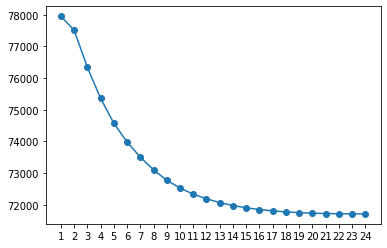

In [22]:
# plot scores
days = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()